## sentiment analysis on a dataset of movie reviews, where each phrase is labeled on a scale of zero to four representing different sentiments²



##### tools & libraries used:

    TensorFlow GPU version 2.14.0
    NumPy for numerical operations
    Pandas for data manipulation
    Matplotlib for data visualization
    Keras for building and training the LSTM neural network
    Scikit-learn for data preprocessing

In [1]:
import tensorflow.config as tf_conf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D


2024-02-01 13:41:50.693000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:41:50.693039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:41:50.693050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 13:41:50.708021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head()

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head()

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [4]:
replace_list = {
    r"i'm": 'i am',
    r"'re": ' are',
    r"let’s": 'let us',
    r"'s":  ' is',
    r"'ve": ' have',
    r"can't": 'can not',
    r"cannot": 'can not',
    r"shan’t": 'shall not',
    r"n't": ' not',
    r"'d": ' would',
    r"'ll": ' will',
    r"'scuse": 'excuse',
    ',': ' ,',
    '.': ' .',
    '!': ' !',
    '?': ' ?',
    '\s+': ' '}
print(replace_list)

{"i'm": 'i am', "'re": ' are', 'let’s': 'let us', "'s": ' is', "'ve": ' have', "can't": 'can not', 'cannot': 'can not', 'shan’t': 'shall not', "n't": ' not', "'d": ' would', "'ll": ' will', "'scuse": 'excuse', ',': ' ,', '.': ' .', '!': ' !', '?': ' ?', '\\s+': ' '}


In [5]:
def clean_text(text):
    text = text.lower()
    for i in replace_list:
        text = text.replace(i, replace_list[i])
    text = ' '.join(text.split())
    return text

In [6]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


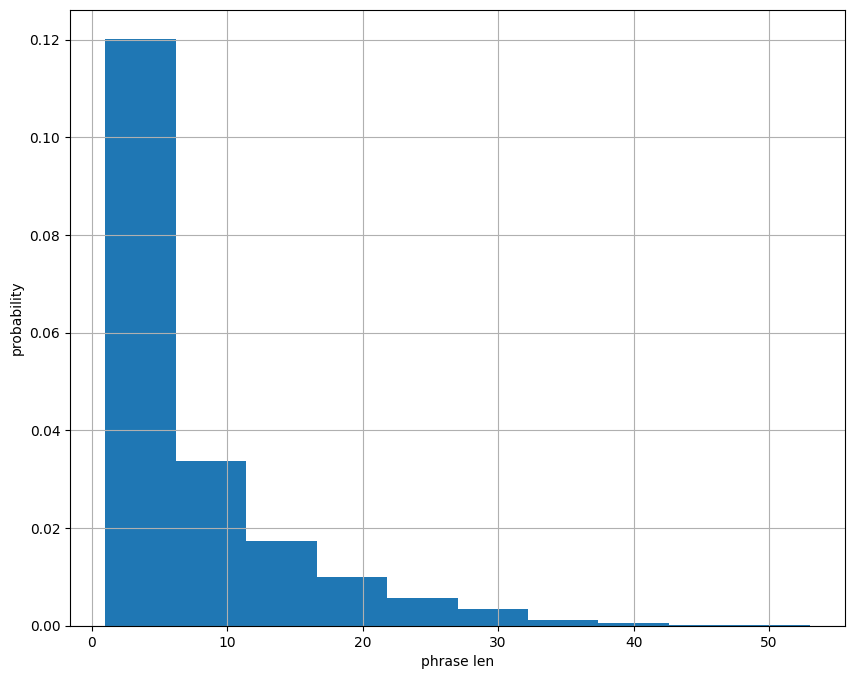

In [7]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid()

In [8]:
y_train = df_train['Sentiment']
y_train

0         1
1         2
2         2
3         2
4         2
         ..
156055    2
156056    1
156057    3
156058    2
156059    2
Name: Sentiment, Length: 156060, dtype: int64

In [9]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [10]:
# batch_size = 512
# epochs = 16

In [11]:
physical_devices = tf_conf.list_physical_devices('GPU') 
tf_conf.experimental.set_memory_growth(physical_devices[0], True)

2024-02-01 13:42:04.114170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:42:04.198461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:42:04.198800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

2024-02-01 13:42:04.216872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:42:04.217581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:42:04.218168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 1024
)

Epoch 1/8


2024-02-01 13:42:11.897302: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2f7c032220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 13:42:11.897360: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-02-01 13:42:11.907471: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-01 13:42:12.074881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-02-01 13:42:12.187964: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 72s 464ms/step - loss: 1.1147 - accuracy: 0.5572 - val_loss: 1.0285 - val_accuracy: 0.5848
Epoch 2/8
138/138 [==============================] - 50s 363ms/step - loss: 0.8703 - accuracy: 0.6519 - val_loss: 1.0022 - val_accuracy: 0.5987
Epoch 3/8
138/138 [==============================] - 49s 352ms/step - loss: 0.8135 - accuracy: 0.6732 - val_loss: 1.0047 - val_accuracy: 0.6027
Epoch 4/8
138/138 [==============================] - 51s 369ms/step - loss: 0.7818 - accuracy: 0.6840 - val_loss: 1.0178 - val_accuracy: 0.6016
Epoch 5/8
138/138 [==============================] - 51s 367ms/step - loss: 0.7560 - accuracy: 0.6937 - val_loss: 1.0248 - val_accuracy: 0.6043
Epoch 6/8
138/138 [==============================] - 51s 370ms/step - loss: 0.7333 - accuracy: 0.6999 - val_loss: 1.0646 - val_accuracy: 0.6030
Epoch 7/8
138/138 [==============================] - 44s 322ms/step - loss: 0.7163 - accuracy: 0.7066 - val_loss: 1.0736 - val_accuracy: 0.5985
Ep

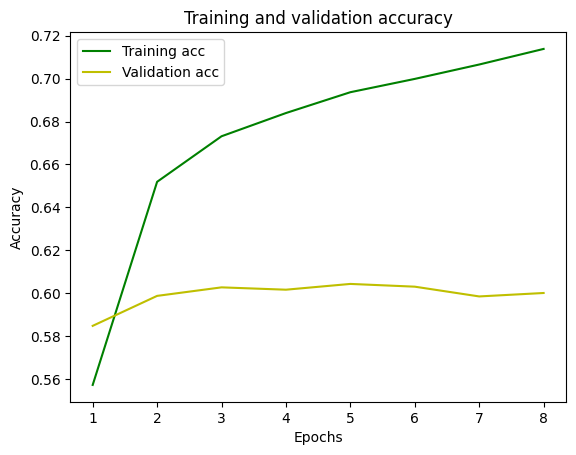

In [14]:
plt.clf()
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']  
plt.plot(range(1, 9), acc, 'g', label='Training acc')  
plt.plot(range(1, 9), val_acc, 'y', label='Validation acc') 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
model_json = model_lstm.to_json()
with open('sentiment_analysis_model.json', 'w') as json_file:
    json_file.write(model_json)

model_lstm.save_weights('sentiment_analysis_weights.h5')